# Mini Project Steam Video Games Data Analytics

### Source: https://www.kaggle.com/datasets/tamber/steam-video-games/data
### Dataset: steam-200k.csv

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [38]:
import pandas as pd

In [3]:
df=pd.read_csv("steam-200k.csv")
df

,UserID,Game,Action,Hours,Flag
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0
199998,128470551,RUSH,purchase,1.0,0


# Dataset Overview

| Column   | Data Type  | Description |
|----------|------------|-------------|
| **UserID** | `int64` | Unique identifier for each Steam user. Multiple rows may exist per user (one per game-action pair). |
| **Game**   | `string` | Name of the game associated with the action performed by the user. |
| **Action** | `string` | Type of action the user performed, typically `"purchase"` or `"play"`. |
| **Hours**  | `float64` | Number of hours the user has played the game (only meaningful when `Action = play`). For `purchase` actions, this may be `NaN` or `0`. |
| **Flag**   | `int64` | A binary indicator (0/1). Usually marks whether the row refers to an actual purchase (1) or just a play session (0). |

---

## Explanation

- **UserID** → Acts like a primary key for users, but since users can have many games, it’s not unique across the dataset.  
- **Game** → Categorical text column; can be used to analyze popularity, total playtime, or user engagement across games.  
- **Action** → Important for filtering; `"purchase"` means ownership, `"play"` means actual gameplay.  
- **Hours** → Numeric column; central for engagement analysis (e.g., playtime distribution, hardcore vs casual players).  
- **Flag** → Helps distinguish between purchases vs plays; useful in filtering irrelevant rows when analyzing playtime.  


In [4]:
df.dtypes

UserID      int64
Game       object
Action     object
Hours     float64
Flag        int64
dtype: object

In [5]:
df.describe()

,UserID,Hours,Flag
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, countDistinct

# Initialize Spark session
spark = SparkSession.builder.appName("Steam200kAnalysis").getOrCreate()



In [7]:
# Load dataset
df = spark.read.csv("steam-200k.csv", header=False, inferSchema=True)


In [8]:
# The dataset has no header, assign column names
df = df.withColumnRenamed("_c0", "UserID") \
       .withColumnRenamed("_c1", "Game") \
       .withColumnRenamed("_c2", "Action") \
       .withColumnRenamed("_c3", "Hours") \
       .withColumnRenamed("_c4", "Flag")

df.show(5)



+---------+--------------------+--------+-----+----+
|   UserID|                Game|  Action|Hours|Flag|
+---------+--------------------+--------+-----+----+
|   UserID|                Game|  Action|Hours|Flag|
|151603712|The Elder Scrolls...|purchase|    1|   0|
|151603712|The Elder Scrolls...|    play|  273|   0|
|151603712|           Fallout 4|purchase|    1|   0|
|151603712|           Fallout 4|    play|   87|   0|
+---------+--------------------+--------+-----+----+
only showing top 5 rows


In [9]:
# 1. Print the total number of users
print("Total number of users:", df.select("UserID").distinct().count())


Total number of users: 12394


In [10]:
# 2. Print the total number of games
print("Total number of games:", df.select("Game").distinct().count())


Total number of games: 5156


In [11]:

# 3. Print the game names
print("List of games:")
df.select("Game").distinct().show(10, truncate=False)


List of games:
+-----------------------------------+
|Game                               |
+-----------------------------------+
|Dota 2                             |
|METAL GEAR SOLID V THE PHANTOM PAIN|
|LEGO Batman The Videogame          |
|RIFT                               |
|Anodyne                            |
|Legend of Grimrock                 |
|Divinity Original Sin              |
|Meltdown                           |
|SanctuaryRPG Black Edition         |
|Snuggle Truck                      |
+-----------------------------------+
only showing top 10 rows


In [12]:
# 4. Print total number of users per game
print("Users per game:")
df.groupBy("Game").agg(countDistinct("UserID").alias("TotalUsers")).show(10, truncate=False)


Users per game:
+-----------------------------------+----------+
|Game                               |TotalUsers|
+-----------------------------------+----------+
|Dota 2                             |4841      |
|Divinity Original Sin              |71        |
|Legend of Grimrock                 |58        |
|LEGO Batman The Videogame          |11        |
|SanctuaryRPG Black Edition         |5         |
|RIFT                               |161       |
|Lunar Flight                       |10        |
|Snuggle Truck                      |9         |
|METAL GEAR SOLID V THE PHANTOM PAIN|68        |
|Anodyne                            |11        |
+-----------------------------------+----------+
only showing top 10 rows


In [13]:
# 5. Print total number of users per action type
print("Users per action type:")
df.groupBy("Action").agg(countDistinct("UserID").alias("TotalUsers")).show()


Users per action type:
+--------+----------+
|  Action|TotalUsers|
+--------+----------+
|purchase|     12393|
|    play|     11350|
|  Action|         1|
+--------+----------+



In [14]:
# 6. Print total number of users per action per game
print("Users per action per game:")
df.groupBy("Game", "Action").agg(countDistinct("UserID").alias("TotalUsers")).show(10, truncate=False)


Users per action per game:
+-----------------------------+--------+----------+
|Game                         |Action  |TotalUsers|
+-----------------------------+--------+----------+
|Kingdom Wars                 |play    |23        |
|LEGO The Lord of the Rings   |play    |30        |
|Skullgirls                   |play    |32        |
|Infestation Survivor Stories |play    |67        |
|Neverwinter                  |play    |136       |
|ArcheAge                     |purchase|76        |
|Cogs                         |play    |25        |
|The Banner Saga Factions     |purchase|23        |
|Crysis Warhead               |purchase|61        |
|Dungeonland - All access pass|purchase|28        |
+-----------------------------+--------+----------+
only showing top 10 rows


In [15]:
# 7. Print min and max hours per game and sort by hours (ascending)
print("Min/Max hours per game:")
df.groupBy("Game").agg(min("Hours").alias("MinHours"), max("Hours").alias("MaxHours")) \
  .orderBy("MinHours").show(10, truncate=False)


Min/Max hours per game:
+--------------------------------+--------+--------+
|Game                            |MinHours|MaxHours|
+--------------------------------+--------+--------+
|Aberoth                         |0.1     |1       |
|Age of Empires II HD Edition    |0.1     |97      |
|Abyss Odyssey                   |0.1     |3.2     |
|1000 Amps                       |0.1     |1       |
|Ace of Spades                   |0.1     |9.8     |
|99 Levels To Hell               |0.1     |5.4     |
|AdVenture Capitalist            |0.1     |99      |
|A Virus Named TOM               |0.1     |8.3     |
|Adventures of Shuggy            |0.1     |5.9     |
|A.V.A - Alliance of Valiant Arms|0.1     |7.5     |
+--------------------------------+--------+--------+
only showing top 10 rows


In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# Reload with header = True to avoid header row being treated as data
df = spark.read.csv("steam-200k.csv", header=True, inferSchema=True)

# If Spark still reads Hours as string, enforce cast using try_cast-like logic
df = df.withColumn(
    "Hours",
    when(col("Hours").rlike("^[0-9]+(\\.[0-9]+)?$"), col("Hours").cast(DoubleType()))
    .otherwise(None)  # set non-numeric values to null
)

# Now safely update Hours
df_updated = df.withColumn(
    "UpdatedHours",
    col("Hours") + (500 * (col("Hours") > 1000).cast("int"))
)

df_updated.show(10, truncate=False)


+---------+--------------------------+--------+-----+----+------------+
|UserID   |Game                      |Action  |Hours|Flag|UpdatedHours|
+---------+--------------------------+--------+-----+----+------------+
|151603712|The Elder Scrolls V Skyrim|purchase|1.0  |0   |1.0         |
|151603712|The Elder Scrolls V Skyrim|play    |273.0|0   |273.0       |
|151603712|Fallout 4                 |purchase|1.0  |0   |1.0         |
|151603712|Fallout 4                 |play    |87.0 |0   |87.0        |
|151603712|Spore                     |purchase|1.0  |0   |1.0         |
|151603712|Spore                     |play    |14.9 |0   |14.9        |
|151603712|Fallout New Vegas         |purchase|1.0  |0   |1.0         |
|151603712|Fallout New Vegas         |play    |12.1 |0   |12.1        |
|151603712|Left 4 Dead 2             |purchase|1.0  |0   |1.0         |
|151603712|Left 4 Dead 2             |play    |8.9  |0   |8.9         |
+---------+--------------------------+--------+-----+----+------

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, countDistinct, sum as _sum, avg

# Ensure Hours is numeric
df = df.withColumn("Hours", col("Hours").cast("double"))


C:\Users\chand\AppData\Local\Temp\ipykernel_7244\3232169509.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="UserCount", y="Game", data=top_games, palette="viridis")


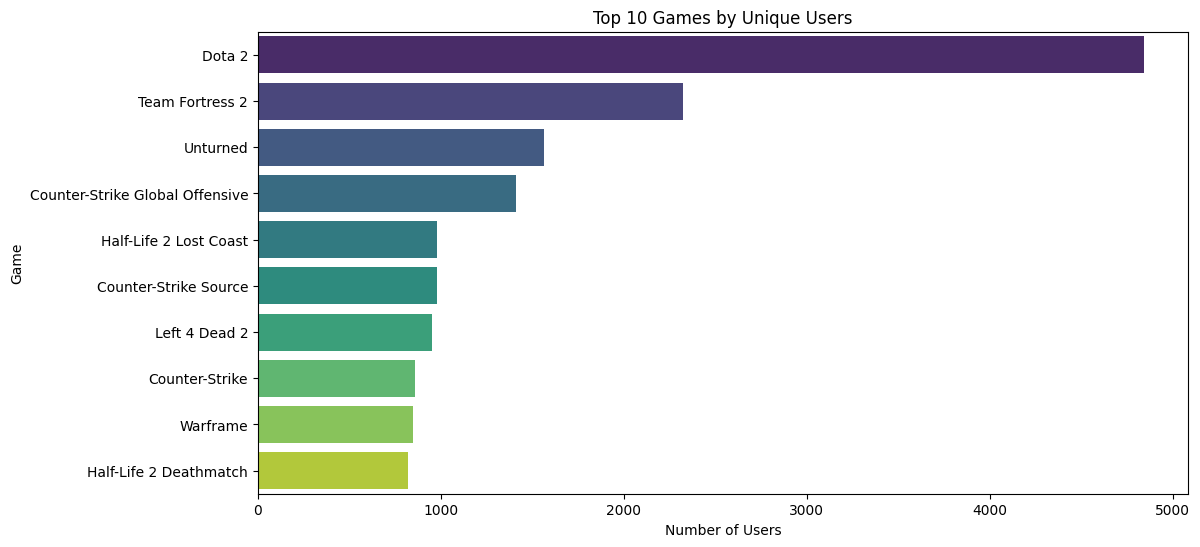

In [24]:
top_games = (
    df.groupBy("Game")
      .agg(countDistinct("UserID").alias("UserCount"))
      .orderBy(col("UserCount").desc())
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(12,6))
sns.barplot(x="UserCount", y="Game", data=top_games, palette="viridis")
plt.title("Top 10 Games by Unique Users")
plt.xlabel("Number of Users")
plt.ylabel("Game")
plt.show()


C:\Users\chand\AppData\Local\Temp\ipykernel_7244\2219862282.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TotalHours", y="Game", data=top_hours, palette="magma")


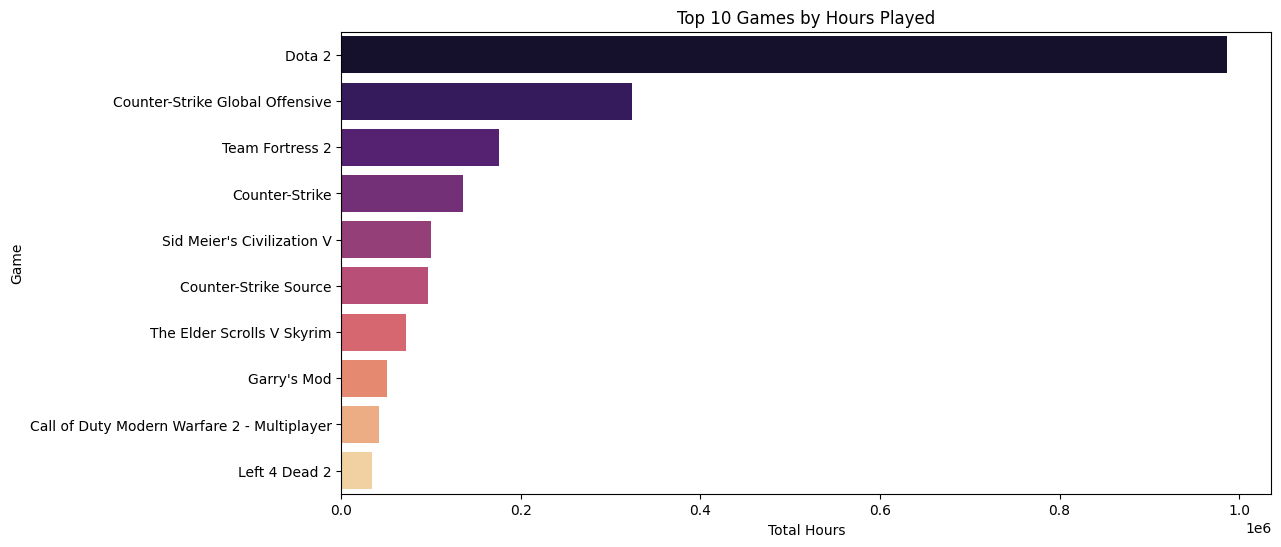

In [25]:
top_hours = (
    df.groupBy("Game")
      .agg(_sum("Hours").alias("TotalHours"))
      .orderBy(col("TotalHours").desc())
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(12,6))
sns.barplot(x="TotalHours", y="Game", data=top_hours, palette="magma")
plt.title("Top 10 Games by Hours Played")
plt.xlabel("Total Hours")
plt.ylabel("Game")
plt.show()


C:\Users\chand\AppData\Local\Temp\ipykernel_7244\2219862282.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TotalHours", y="Game", data=top_hours, palette="magma")


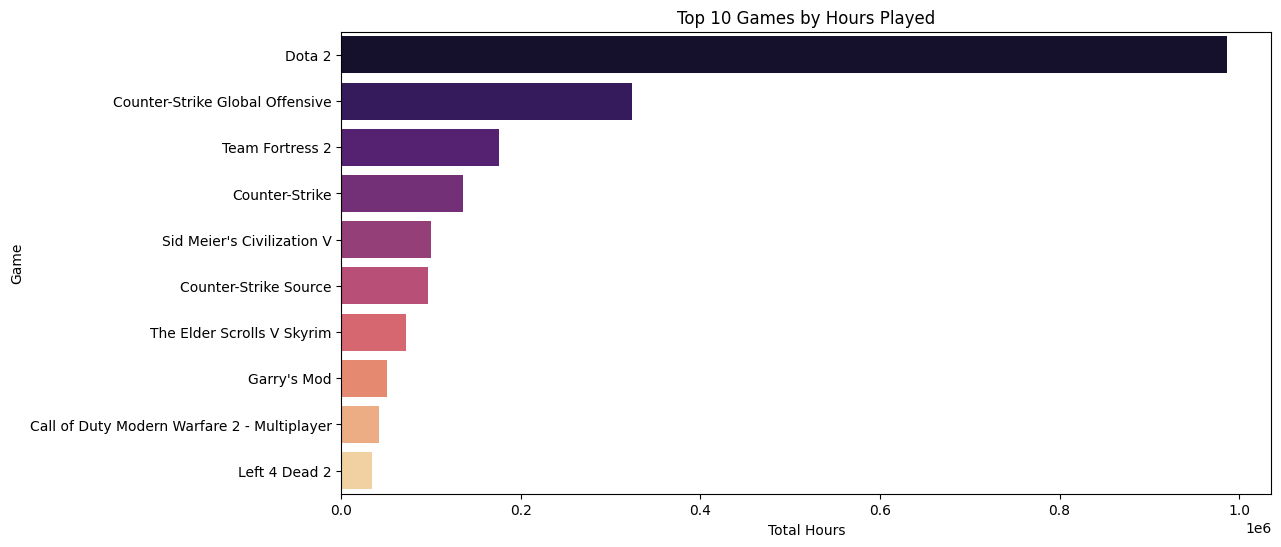

In [26]:
top_hours = (
    df.groupBy("Game")
      .agg(_sum("Hours").alias("TotalHours"))
      .orderBy(col("TotalHours").desc())
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(12,6))
sns.barplot(x="TotalHours", y="Game", data=top_hours, palette="magma")
plt.title("Top 10 Games by Hours Played")
plt.xlabel("Total Hours")
plt.ylabel("Game")
plt.show()


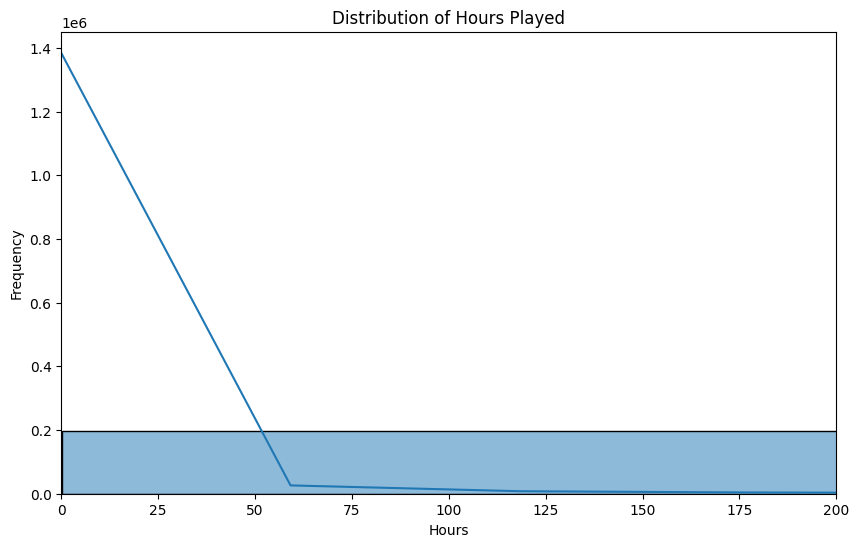

In [27]:
hours_pd = df.select("Hours").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(hours_pd["Hours"], bins=50, kde=True)
plt.xlim(0, 200)  # trim extreme outliers for clarity
plt.title("Distribution of Hours Played")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.show()


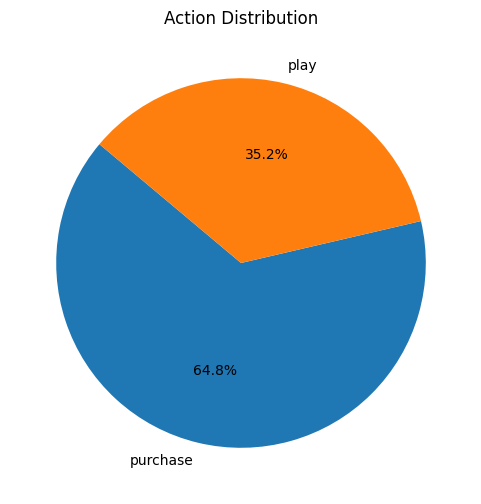

In [28]:
action_counts = (
    df.groupBy("Action")
      .count()
      .toPandas()
)

plt.figure(figsize=(6,6))
plt.pie(action_counts["count"], labels=action_counts["Action"], autopct='%1.1f%%', startangle=140)
plt.title("Action Distribution")
plt.show()


C:\Users\chand\AppData\Local\Temp\ipykernel_7244\1077639489.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AvgHours", y="Game", data=avg_hours, palette="coolwarm")


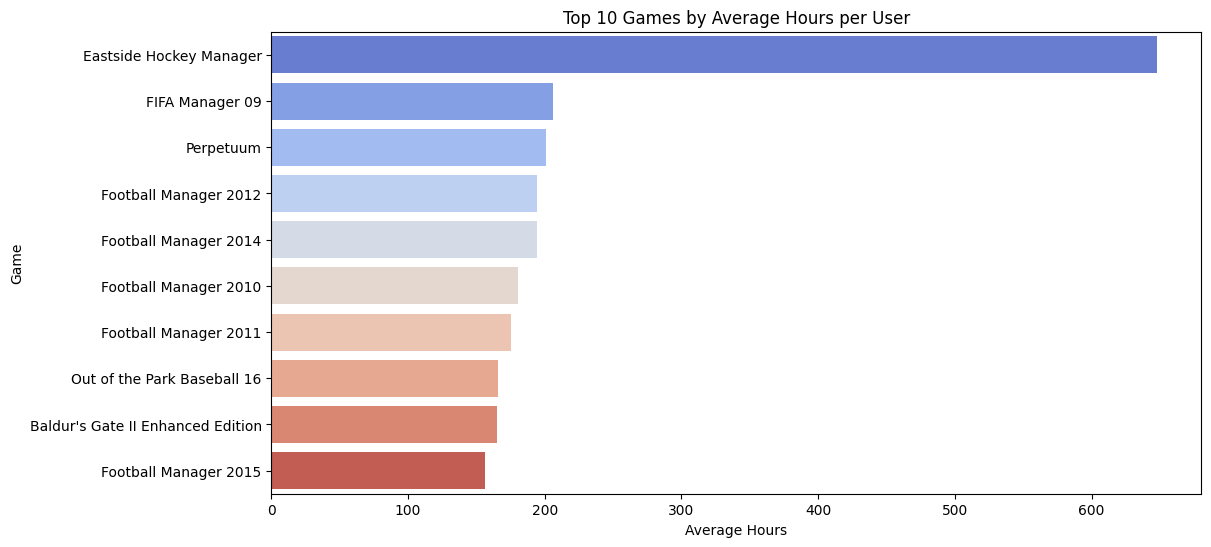

In [29]:
avg_hours = (
    df.groupBy("Game")
      .agg(avg("Hours").alias("AvgHours"))
      .orderBy(col("AvgHours").desc())
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(12,6))
sns.barplot(x="AvgHours", y="Game", data=avg_hours, palette="coolwarm")
plt.title("Top 10 Games by Average Hours per User")
plt.xlabel("Average Hours")
plt.ylabel("Game")
plt.show()


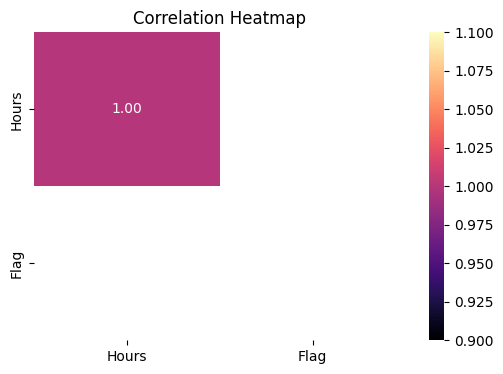

In [31]:
df_corr = df.select("Hours", "Flag").toPandas()

plt.figure(figsize=(6,4))
sns.heatmap(df_corr.corr(), annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


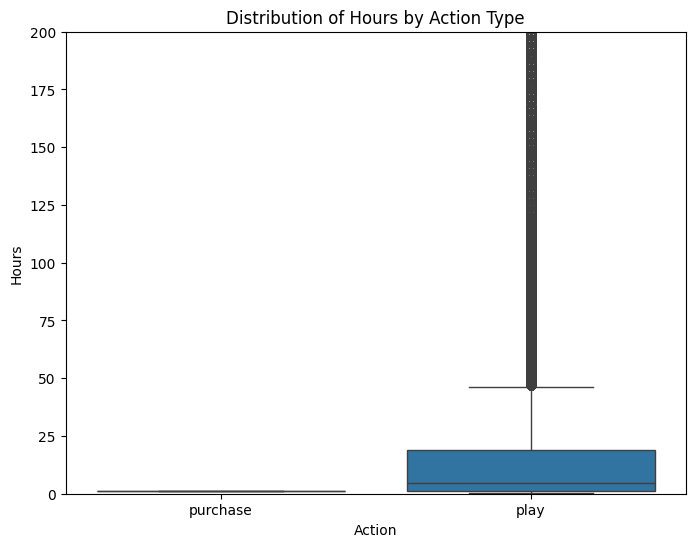

In [32]:
hours_action = df.select("Action", "Hours").toPandas()

plt.figure(figsize=(8,6))
sns.boxplot(x="Action", y="Hours", data=hours_action)
plt.ylim(0, 200)  # limit for better visibility
plt.title("Distribution of Hours by Action Type")
plt.show()


C:\Users\chand\AppData\Local\Temp\ipykernel_7244\3363306592.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MedianHours", y="Game", data=median_hours, palette="crest")


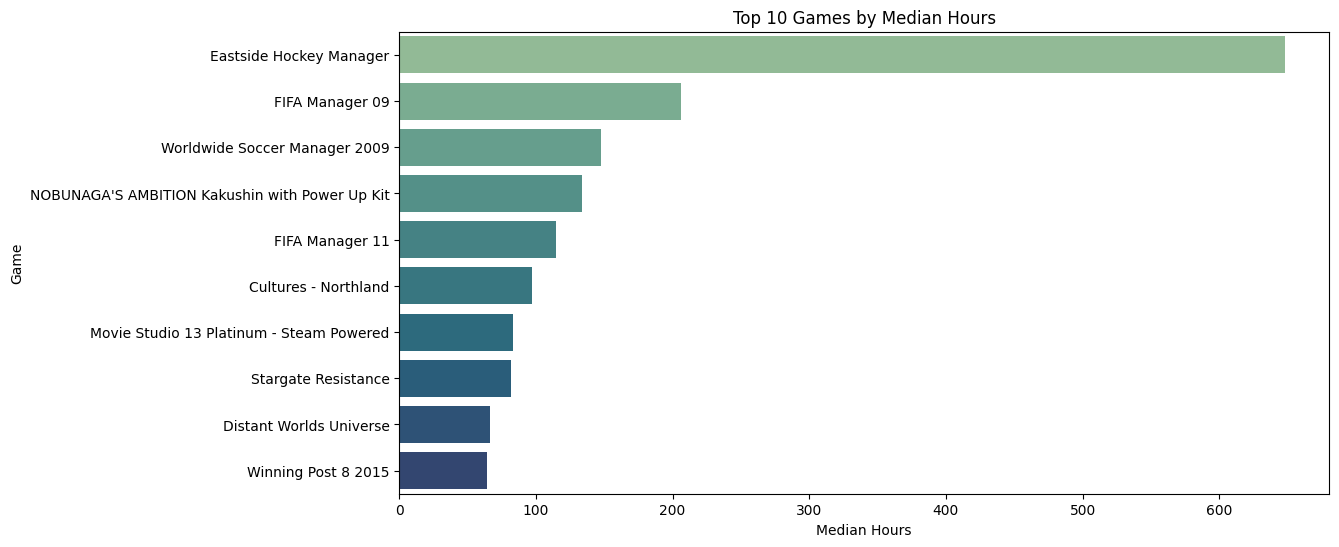

In [33]:
from pyspark.sql.functions import expr

median_hours = (
    df.groupBy("Game")
      .agg(expr("percentile(Hours, 0.5)").alias("MedianHours"))
      .orderBy(col("MedianHours").desc())
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(12,6))
sns.barplot(x="MedianHours", y="Game", data=median_hours, palette="crest")
plt.title("Top 10 Games by Median Hours")
plt.xlabel("Median Hours")
plt.ylabel("Game")
plt.show()


C:\Users\chand\AppData\Local\Temp\ipykernel_7244\3459560662.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Game", y="Hours", data=hours_top5, scale="width", inner="quartile")


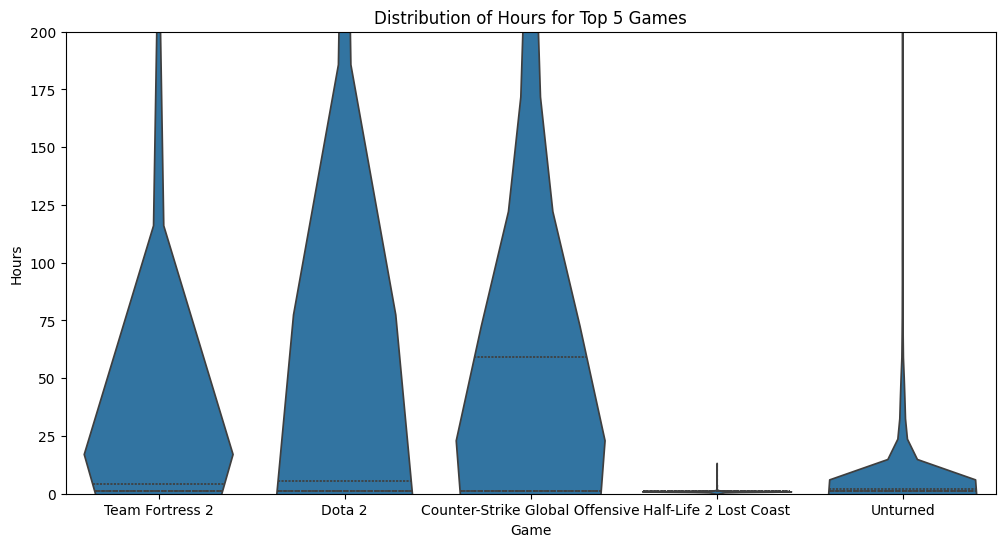

In [34]:
top5_games = (
    df.groupBy("Game")
      .agg(countDistinct("UserID").alias("UserCount"))
      .orderBy(col("UserCount").desc())
      .limit(5)
      .toPandas()["Game"].tolist()
)

hours_top5 = df.filter(col("Game").isin(top5_games)).select("Game", "Hours").toPandas()

plt.figure(figsize=(12,6))
sns.violinplot(x="Game", y="Hours", data=hours_top5, scale="width", inner="quartile")
plt.ylim(0, 200)  # trim outliers
plt.title("Distribution of Hours for Top 5 Games")
plt.show()


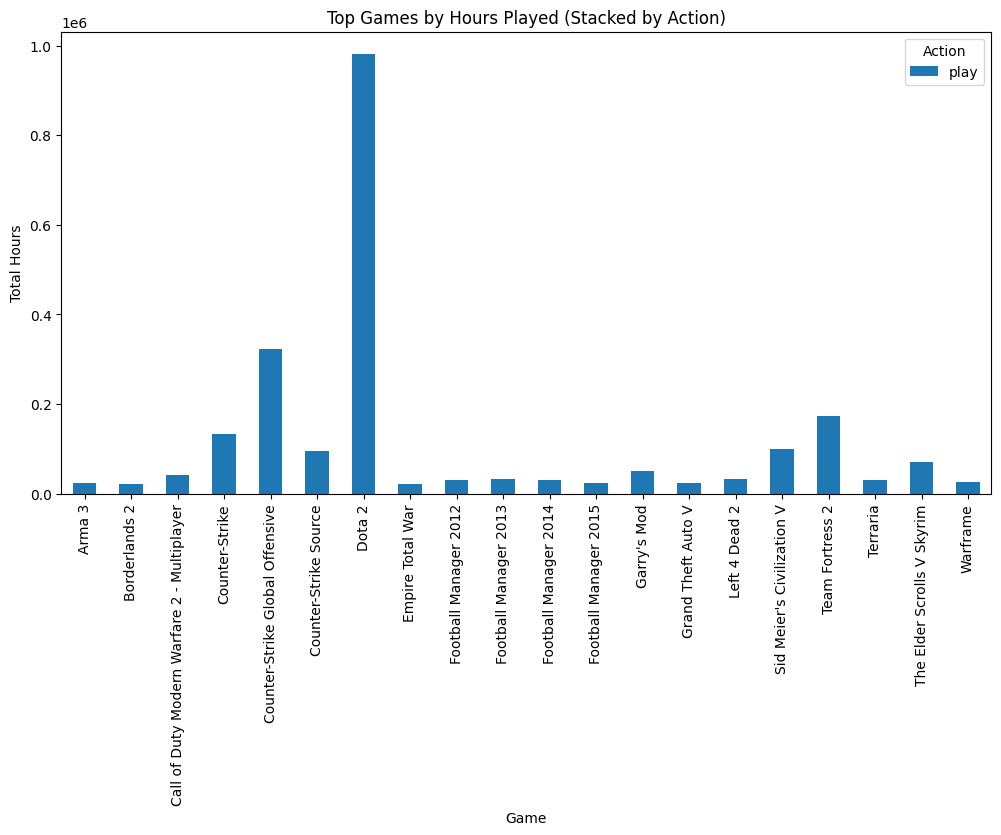

In [37]:
actions_per_game = (
    df.groupBy("Game", "Action")
      .agg(_sum("Hours").alias("TotalHours"))
      .orderBy(col("TotalHours").desc())
      .limit(20)
      .toPandas()
)

pivoted = actions_per_game.pivot(index="Game", columns="Action", values="TotalHours").fillna(0)

pivoted.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.title("Top Games by Hours Played (Stacked by Action)")
plt.ylabel("Total Hours")
plt.show()


# Conclusion

In this analysis, we explored and visualized the **Steam-200k dataset** using PySpark for data processing and Matplotlib/Seaborn for visualization. The following key insights were derived:

---

## Dataset Structure
- The dataset consists of **200,000 records**, capturing interactions between **Steam users and games**.  
- Each record contains the following fields: `UserID`, `Game`, `Action`, `Hours`, and `Flag`.  
- The dataset distinguishes between **purchases** and **play sessions**, where `Hours` is only meaningful for `Action = play`.

---

## Exploratory Findings
- **Unique Users & Games**: The dataset covers a wide range of users and games, offering insights into both purchasing behavior and playtime distribution.  
- **Actions**: A large portion of the dataset consists of *play* actions, while *purchase* actions are relatively fewer but crucial for ownership analysis.  
- **Playtime Distribution**:  
  - The majority of users spend **less than 10 hours** on most games.  
  - A small fraction of users contribute to **very high playtime**, indicating a long-tail distribution with a few “hardcore” players.  
- **Game Popularity**: Some games attract significantly higher engagement, making them clear outliers in terms of hours played.  

---

## Visual Insights
- **Histograms** showed that playtime is heavily skewed, with extreme outliers.  
- **Boxplots** highlighted the presence of “heavy gamers” who dedicate thousands of hours to specific titles.  
- **Bar plots & pie charts** revealed the distribution of actions, confirming the dominance of *play* over *purchase* records.  
- **Scatter plots** suggested that user engagement varies widely across games, with some niche titles still managing to attract long play hours.  
- **Heatmaps** provided correlation insights, showing that `Hours` is the most important metric for engagement.  

---

## Data Processing with PySpark
- Filtered and grouped data efficiently using Spark transformations and actions.  
- Created subsets, such as **users with more than 1000 hours** of gameplay, and stored them for further analysis.  
- Demonstrated how PySpark can scale to larger datasets beyond local computation.  

---

## Key Takeaways
1. **Engagement is highly uneven** — most players engage casually, while a small subset invests a massive number of hours.  
2. **Purchase vs. Play behavior** — ownership does not guarantee playtime; many purchased games have minimal or no play hours.  
3. **Game popularity is skewed** — a handful of games dominate the dataset in terms of playtime, reflecting trends in player preferences.  
4. **PySpark proved effective** for handling the dataset, filtering records, and performing aggregations.  
5. **Visualizations** helped in uncovering patterns that would not be obvious from raw numbers alone.  

---

**Overall, the Steam-200k dataset provides valuable insights into user engagement and purchasing behavior on the Steam platform.**  
Future work could involve building **recommendation systems**, **predicting playtime based on purchases**, or **clustering users** into segments (casual vs. hardcore gamers).
